### K-means
-------------

In the following code, i implemented the **K-means clustering algorithm** using the **Wine dataset**. I implemented the core steps of K-means, including **random centroid initialization**, **label assignment based on Euclidean distance**, **centroid recomputation**, and **iteration until convergence**, along with **visualization of the clustering process using PCA**. Finally, i compared the results of our implementation with the **built-in KMeans implementation from sklearn**.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found in: /content/drive/MyDrive/wine_dataset.csv


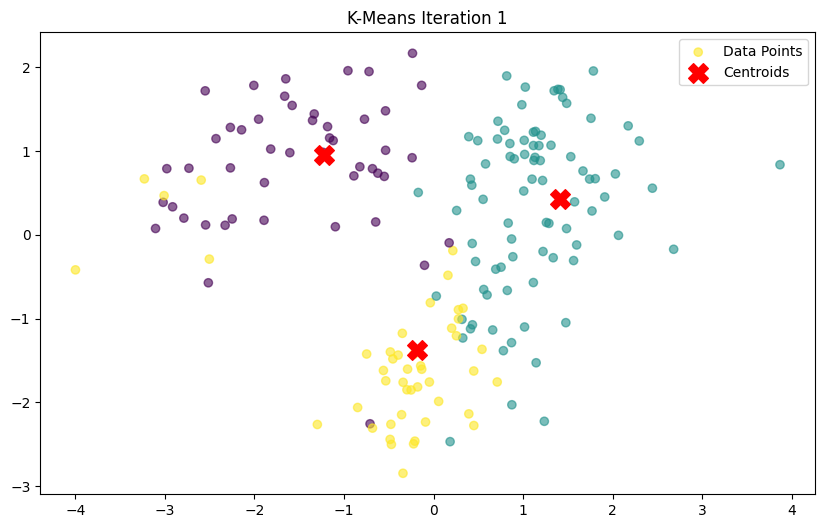

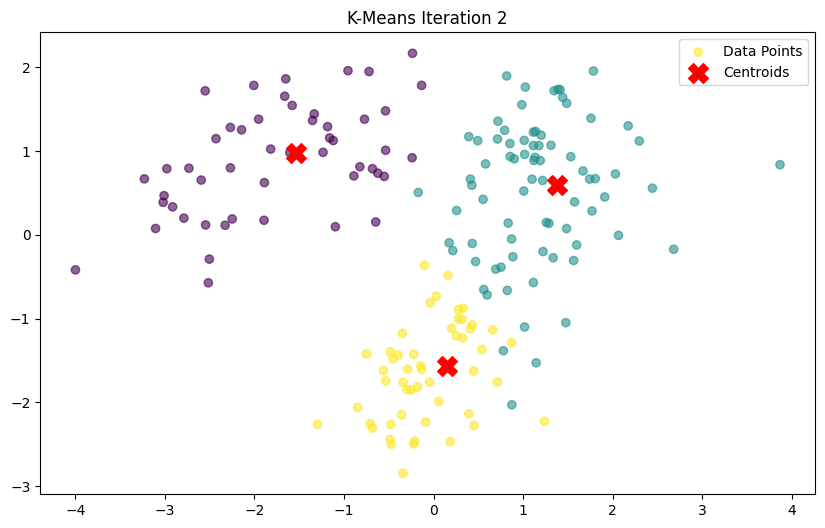

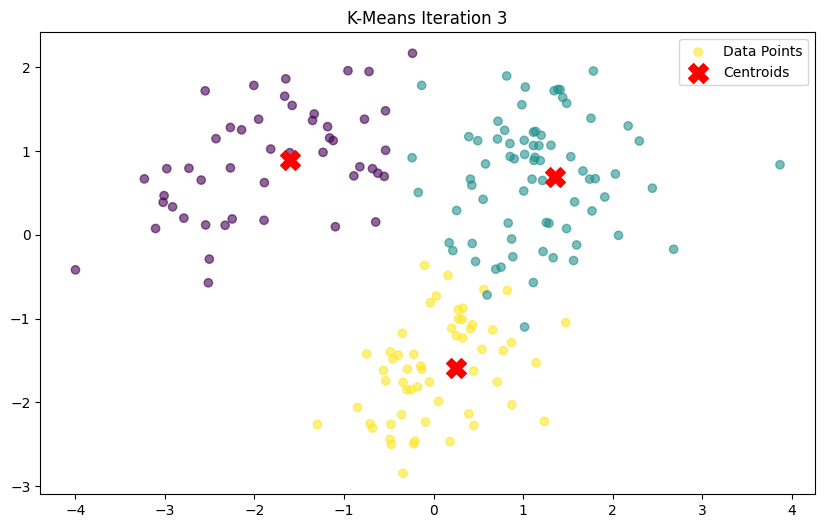

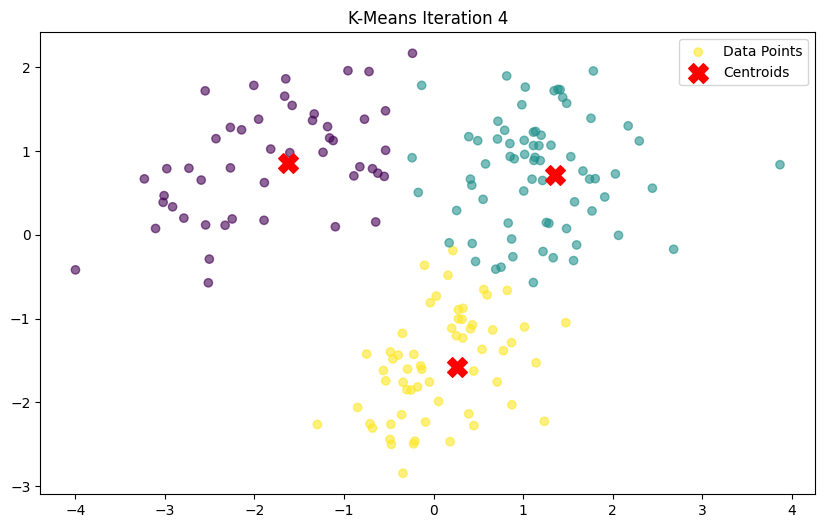

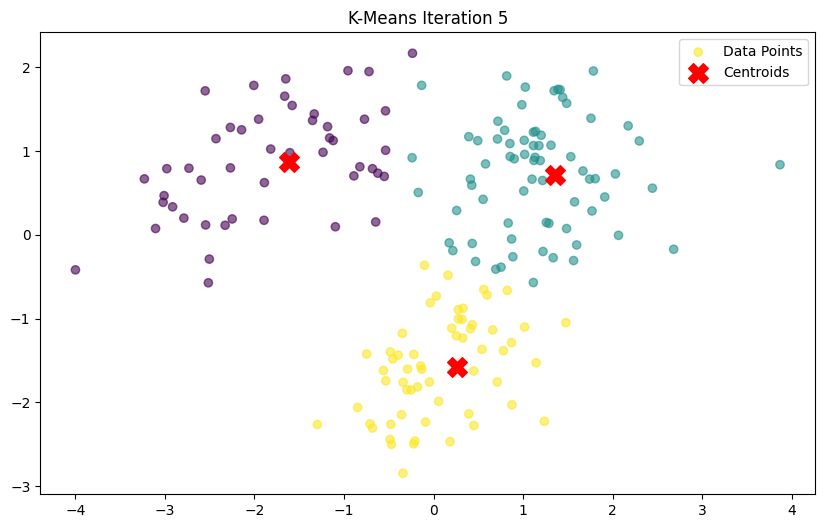

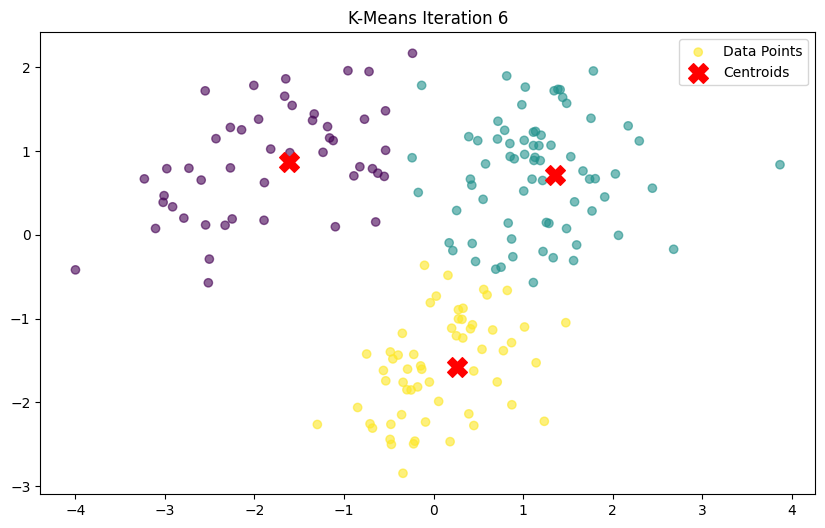

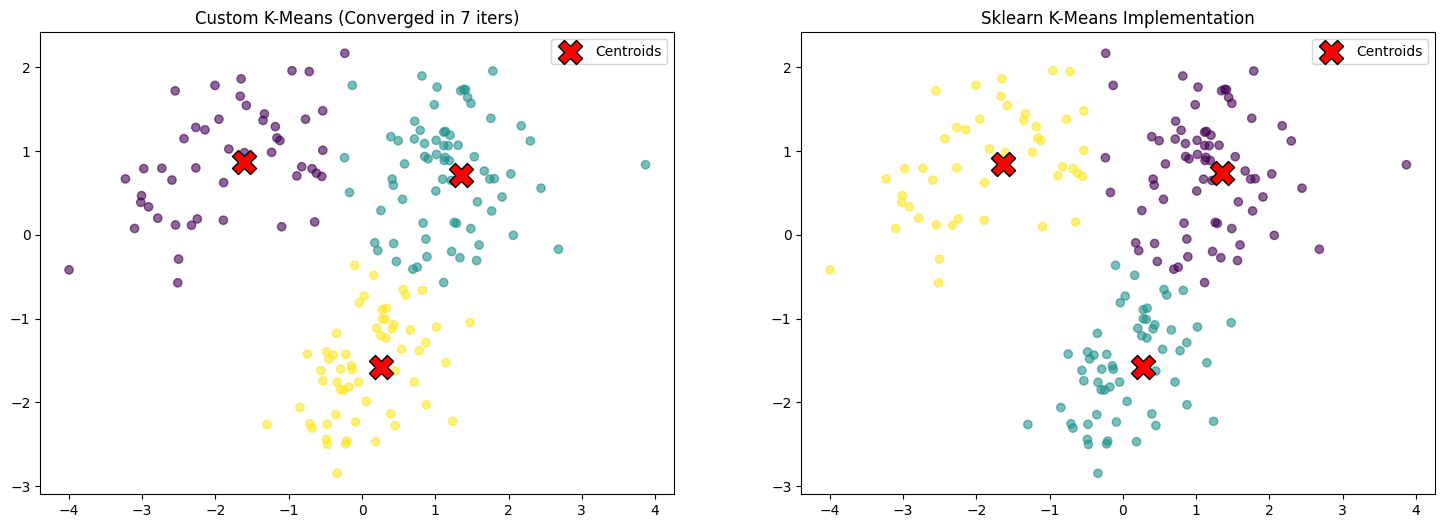


CENTROIDS

--- Custom K-Means Centroids ---


,Cluster_0,Cluster_1,Cluster_2
Feature,,,
alcohol,0.189159,-0.836220,0.852407
magnesium,-0.030127,-0.578174,0.720278
flavanoids,-1.252761,0.030428,0.982579
color_intensity,1.011418,-0.834338,0.181186
hue,-1.205382,0.387265,0.514619



--- Sklearn K-Means Centroids ---


,Cluster_0,Cluster_1,Cluster_2
Feature,,,
alcohol,-0.837484,0.852407,0.212911
magnesium,-0.580619,0.720278,-0.014721
flavanoids,0.008263,0.982579,-1.246108
color_intensity,-0.830009,0.181186,1.044056
hue,0.369246,0.514619,-1.211664


In [17]:
import os
import random
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

import sys
import importlib.util
sys.path.append("/content/drive/MyDrive/machine learning")

pca_path = "/content/drive/MyDrive/machine learning/PCA.py"
spec = importlib.util.spec_from_file_location("PCA_module", pca_path)
PCA_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(PCA_module)

PCA = PCA_module.PCA

import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# ---------------------------------------------------------
#LOAD
# ---------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = '/content/drive/MyDrive/wine_dataset.csv'

if not os.path.exists(file_path):
    print("File is not in Drive. Importing from sklearn...")
    raw_data = load_wine()
    df = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
    df['target'] = raw_data.target
    df.to_csv(file_path, index=False)
    print(f"Dataset saved in: {file_path}")
else:
    print(f"File found in: {file_path}")

dataframe = pd.read_csv(file_path)

# -------------------------------------------
# -----K-means-----
# -------------------------------------------

features = ["alcohol","magnesium","flavanoids","color_intensity","hue"]
dataframe = dataframe.dropna(subset=features)
data = dataframe[features].copy()

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=features)

def random_centroids(data,k):
  centroids = []
  for i in range(k):
     centroid = data.apply(lambda x: x.sample().iloc[0])
     centroids.append(centroid)
  return pd.concat(centroids,axis=1)

def get_labels(data,centroids):
  distances = centroids.apply(lambda x: np.sqrt(((data-x)**2).sum(axis=1)))
  return distances.idxmin(axis=1)

def new_centroids(data, labels ,k):
  return data.groupby(labels).mean().T

def plot_clusters(data,labels,centroids,iteration):
  pca = PCA(k=2)
  data_2d = pca.fit_transform(data.values)
  centroids_2d = pca.transform(centroids.T.values)

  plt.figure(figsize=(10, 6))
  plt.title(f'K-Means Iteration {iteration}')
  plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels, alpha=0.6, label='Data Points')
  plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], marker='X', s=200, c='red', label='Centroids')
  plt.legend()
  plt.show()

max_iterations = 100
k = 3

centroids = random_centroids(data,k)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
  old_centroids = centroids
  labels = get_labels(data,centroids)
  centroids = new_centroids(data,labels,k)
  plot_clusters(data,labels,centroids,iteration)
  iteration+=1

kmeans = KMeans(3)
kmeans.fit(data)
sk_labels = kmeans.labels_
sk_centroids = kmeans.cluster_centers_

#2.(Plots Side-by-Side)
pca = PCA(k=2)
data_2d = pca.fit_transform(data.values)

custom_centroids_2d = pca.transform(centroids.T.values)
sk_centroids_2d = pca.transform(sk_centroids)            # sklearn gives numpy already

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels, cmap='viridis', alpha=0.6)
ax1.scatter(custom_centroids_2d[:,0], custom_centroids_2d[:,1],
            marker='X', s=300, c='red', edgecolors='black', label='Centroids')
ax1.set_title(f'Custom K-Means (Converged in {iteration} iters)')
ax1.legend()

ax2.scatter(x=data_2d[:,0], y=data_2d[:,1], c=sk_labels, cmap='viridis', alpha=0.6)
ax2.scatter(sk_centroids_2d[:,0], sk_centroids_2d[:,1],
            marker='X', s=300, c='red', edgecolors='black', label='Centroids')
ax2.set_title('Sklearn K-Means Implementation')
ax2.legend()

plt.show()

print("\n" + "="*50)
print("CENTROIDS")
print("="*50)

df_custom = centroids.copy()
df_custom.columns = [f'Cluster_{i}' for i in range(k)]
df_custom.index.name = 'Feature'

df_sklearn = pd.DataFrame(sk_centroids, columns=features).T
df_sklearn.columns = [f'Cluster_{i}' for i in range(k)]
df_sklearn.index.name = 'Feature'

print("\n--- Custom K-Means Centroids ---")
display(df_custom)

print("\n--- Sklearn K-Means Centroids ---")
display(df_sklearn)
